In [151]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix

from scikeras.wrappers import KerasRegressor, KerasClassifier # make keras model understandable to scikit-learn package
# import KerasRegressor
# from keras_tuner.tuners import RandomSearch
# import keras_tuner as kt
# from keras_tuner.engine.hyperparameters import HyperParameters

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import Model, Sequential #put together LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed


import warnings
import os

plt.rcParams['figure.figsize'] = (10,4)
warnings.filterwarnings('ignore')

# 1 standard cycle of datas: 81500:85500

def split_into_windows(X, length):
    windows = []
    for start in range(0, len(X) - length + 1):
        window = X[start:start + length]
        if np.std(window) > 1e-18 : #check if std is greater than 0
            windows.append(window)
    return np.array(windows)

def training_validation_loss():
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

In [152]:
url = (r'C:\data\ATO Logs for ATO_N_Baseline.csv')
url2 = (r'C:\data\NYP OMAP Logs\ATO Logs for ATO_N_220908.csv') 
# url = (r'C:\data\CCL_2022_EB+Baseline\Baseline\OMAP\ATO Logs for ATO_N_Baseline.csv') 
# url2 = (r'C:\data\NYP\NYP OMAP Logs\ATO Logs for ATO_N_220908.csv') 

df = pd.read_csv(url, parse_dates=['Date'])
df2 = pd.read_csv(url2, parse_dates=['Date'])

filters = ['Date', 'Train accel'] 
sample = df[filters]
sample2 = df2[filters]


In [153]:
dataset = sample
index_jump = []

jump_row = None
for i in range(1, len(dataset['Date'])):
    date_diff = dataset['Date'][i] - dataset['Date'][i-1]
    if date_diff > pd.Timedelta(seconds=1):
        print(f"Found a sudden jump between {dataset['Date'][i-1]} and {dataset['Date'][i]}")
        index_jump.append(i)
        jump_row = i

if len(index_jump) > 0:
    print(f"The index the time step jump happens is at: {index_jump}")
else:
    print('No missing time step found')

Found a sudden jump between 2022-10-09 03:53:05 and 2022-10-09 07:10:35
The index the time step jump happens is at: [136861]


In [149]:
#No of frames per second
data = sample['Train accel']
time_constant = 3
window_length = time_constant * 10

# Splitting data into train and test sets
split_train_test = int(len(data)*0.8)
data = sample['Train accel']
data2 = sample2['Train accel']


train = data[:split_train_test]
train1 = data[:index_jump[0]]
train2 = data[index_jump[0]:split_train_test]

test = data[split_train_test:]
test2 = data2[:]

print('train1 shape == {}.'.format(train.shape))
print('train1 shape == {}.'.format(train1.shape))
print('train2 shape == {}.'.format(train2.shape))
print('test shape == {}.'.format(test.shape))
print('test2 shape == {}.'.format(test2.shape))

train1 shape == (171500,).
train1 shape == (136861,).
train2 shape == (34639,).
test shape == (42876,).
test2 shape == (305922,).


In [27]:
# Data standardization
scaler = StandardScaler()
scaler = scaler.fit(train.values.reshape(-1, 1))



# train = scaler.transform(train.values.reshape(-1, 1))
train1 = scaler.transform(train1.values.reshape(-1, 1)) 
train2 = scaler.transform(train2.values.reshape(-1, 1)) 
test = scaler.transform(test.values.reshape(-1, 1))
test2 = scaler.transform(test2.values.reshape(-1, 1))


print('train shape == {}.'.format(train.shape))
print('train1 shape == {}.'.format(train1.shape))
print('train2 shape == {}.'.format(train2.shape))
print('test shape == {}.'.format(test.shape))
print('test2 shape == {}.'.format(test2.shape))

train shape == (171500,).
train1 shape == (136861, 1).
train2 shape == (34639, 1).
test shape == (42876, 1).
test2 shape == (305922, 1).


In [50]:
X_train1 = split_into_windows(train1,window_length)
X_train2 = split_into_windows(train2,window_length)
X_test = split_into_windows(test,window_length)
X_test2 = split_into_windows(test2,window_length)

print('X_train1 shape == {}.'.format(X_train1.shape))
print('X_train2 shape == {}.'.format(X_train2.shape))
print('X_test shape == {}.'.format(X_test.shape))
print('X_test2 shape == {}.'.format(X_test2.shape))

X_train1 shape == (43695, 30, 1).
X_train2 shape == (0,).
X_test shape == (1640, 30, 1).
X_test2 shape == (119829, 30, 1).


In [161]:
# (ORIGINAL)
No_of_test_windows, input_length, input_dim = X_test.shape 
No_of_test_windows2, _ ,_ = X_test2.shape

Length_of_NN = [30,20,10,10,20,30]

def create_model():
    model = Sequential() #create sequential model class
    for index, layer in enumerate(Length_of_NN):
        if index == 0:    
            model.add(LSTM(units=layer, activation='relu',input_shape=(input_length,input_dim), return_sequences=True)) 
            model.add(Dropout(0.1))
        else:
            model.add(LSTM(units=layer, activation='relu', return_sequences=True))
            model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=0.001))
    return model

model = create_model()
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_193 (LSTM)             (None, 30, 30)            3840      
                                                                 
 dropout_193 (Dropout)       (None, 30, 30)            0         
                                                                 
 lstm_194 (LSTM)             (None, 30, 20)            4080      
                                                                 
 dropout_194 (Dropout)       (None, 30, 20)            0         
                                                                 
 lstm_195 (LSTM)             (None, 30, 10)            1240      
                                                                 
 dropout_195 (Dropout)       (None, 30, 10)            0         
                                                                 
 lstm_196 (LSTM)             (None, 30, 10)          

In [162]:
checkpoint_path = "/saved_models/04_12/layer6_drop0.1/cp.ckpt" # TO CHANGE OR REMOVE WHEN SAVING MODELS
cp_callback = ModelCheckpoint(filepath=checkpoint_path,  
                              save_weights_only=True)

history = model.fit(X_train1, X_train1,
                    batch_size = 32, 
                    epochs = 50, 
                    validation_split = 0.1,
                    callbacks = [EarlyStopping(monitor='val_loss', patience=5),
                                cp_callback
                                ])

Epoch 1/50
1229/1229 [==============================] - 69s 51ms/step - loss: 1.2710 - val_loss: 0.2794
Epoch 2/50
1229/1229 [==============================] - 67s 54ms/step - loss: 0.2859 - val_loss: 0.1452
Epoch 3/50
1229/1229 [==============================] - 77s 62ms/step - loss: 0.1742 - val_loss: 0.1325
Epoch 4/50
1229/1229 [==============================] - 74s 60ms/step - loss: 0.1341 - val_loss: 0.0964
Epoch 5/50
1229/1229 [==============================] - 71s 57ms/step - loss: 0.1144 - val_loss: 0.1068
Epoch 6/50
1229/1229 [==============================] - 68s 55ms/step - loss: 0.0997 - val_loss: 0.1170
Epoch 7/50
1229/1229 [==============================] - 69s 56ms/step - loss: 0.0884 - val_loss: 0.1622
Epoch 8/50
1229/1229 [==============================] - 70s 57ms/step - loss: 0.0800 - val_loss: 0.1347
Epoch 9/50
1229/1229 [==============================] - 69s 56ms/step - loss: 0.0736 - val_loss: 0.1453


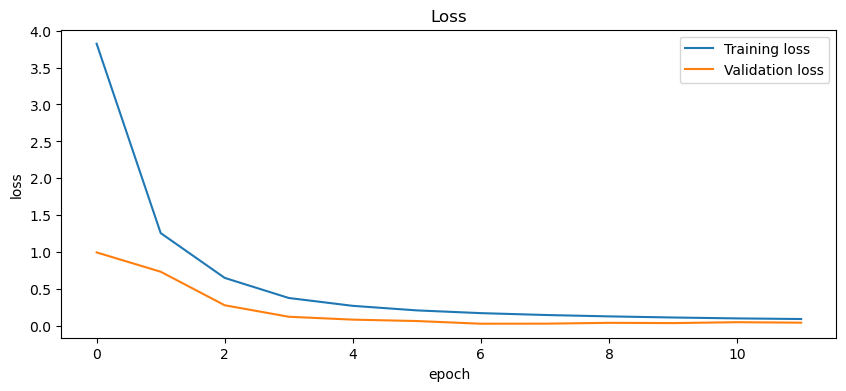

In [157]:
# training_validation_loss()
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

# history = load_model('/testt/1 with save_best_only.h5')

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [158]:
# model.save('/saved_models/29_11/layer6_std_1e-18.h5')
# new_model = load_model('/saved_models/28_11/layer6.h5')

model = create_model()
model.load_weights("/saved_models/04_12/layer6_drop0.1/cp.ckpt")

model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_187 (LSTM)             (None, 30, 30)            3840      
                                                                 
 dropout_187 (Dropout)       (None, 30, 30)            0         
                                                                 
 lstm_188 (LSTM)             (None, 30, 20)            4080      
                                                                 
 dropout_188 (Dropout)       (None, 30, 20)            0         
                                                                 
 lstm_189 (LSTM)             (None, 30, 10)            1240      
                                                                 
 dropout_189 (Dropout)       (None, 30, 10)            0         
                                                                 
 lstm_190 (LSTM)             (None, 30, 10)          

In [159]:
# Taxi: Reconstruction
#Anomaly is where reconstruction error is large.
#We can define this value beyond which we call anomaly. 
#MSE in training prediction
X_train_pred = model.predict(X_train1)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train1), axis=1)

# print(len(X_test)) = model.predict(X_test)
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

X_test_pred2 = model.predict(X_test2)
test_mae_loss2 = np.mean(np.abs(X_test_pred2 - X_test2), axis=1)

3745/3745 [==============================] - 46s 12ms/step


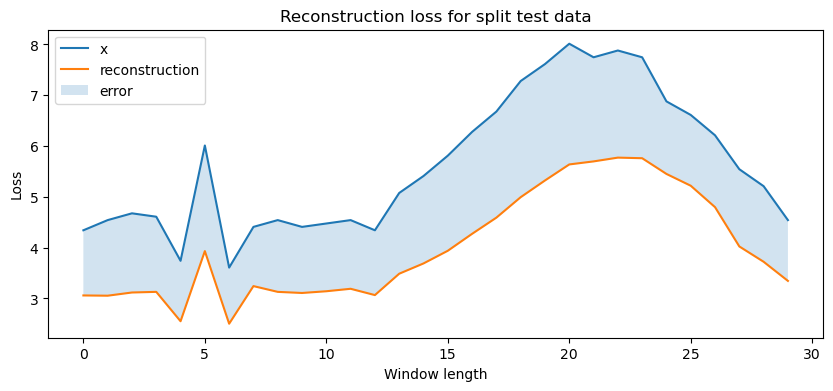

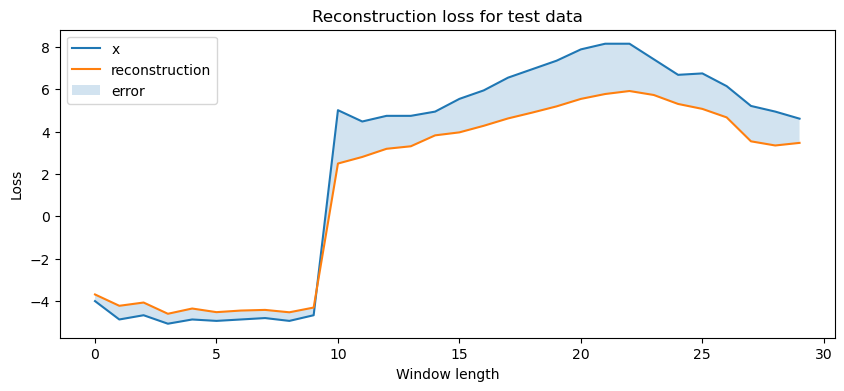

In [129]:
x = X_test[window_length].flatten() #actual data
x_pred = X_test_pred[window_length].flatten() #prediction after training
plt.title('Reconstruction loss for split test data')
plt.xlabel('Window length')
plt.ylabel('Loss')
plt.plot(x, label='x')
plt.plot(x_pred, label='reconstruction')
plt.fill_between(np.arange(window_length), 
                 x, x_pred, 
                 alpha=0.2,
                 label='error'
                )
plt.legend()
plt.show()



x2 = X_test2[window_length].flatten() #actual data
x_pred2 = X_test_pred2[window_length].flatten() #prediction after training

plt.title('Reconstruction loss for test data')
plt.xlabel('Window length')
plt.ylabel('Loss')
plt.plot(x2, label='x')
plt.plot(x_pred2, label='reconstruction')
plt.fill_between(np.arange(window_length), 
                 x2, x_pred2, 
                 alpha=0.2, #transparency of point, default is 1
                 label='error'
                )
plt.legend()
plt.show()

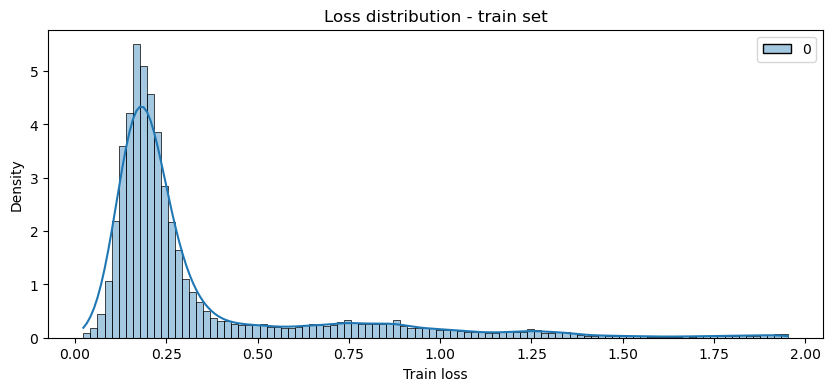

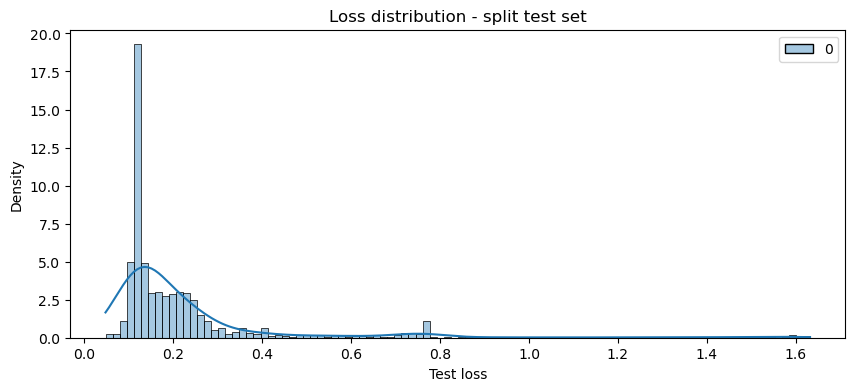

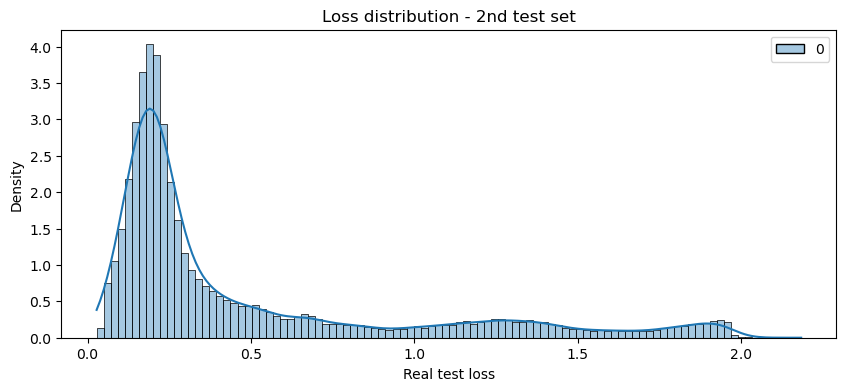

In [130]:
# Loss histogram

plt.title('Loss distribution - train set')
plt.xlabel('Train loss')
sns.histplot(train_mae_loss, kde=True, bins=100, stat="density", alpha=0.4)
plt.show()

plt.title('Loss distribution - split test set')
plt.xlabel('Test loss')
sns.histplot(
    test_mae_loss, kde=True, bins=100, stat="density", alpha=0.4)
plt.show()

plt.title('Loss distribution - 2nd test set')
plt.xlabel('Real test loss')
sns.histplot(test_mae_loss2, kde=True, bins=100, stat="density", alpha=0.4)
plt.show()

In [134]:
threshold1 = np.mean(test_mae_loss) + 3.2 * np.std(test_mae_loss)
threshold2 = np.mean(test_mae_loss2) + 3.2 * np.std(test_mae_loss2)
print('threshold 1 is', threshold1)
print('threshold 2 is', threshold2)
print('standard deviation of 1st test set' ,np.std(test_mae_loss))
print('standard deviation of 2nd test set' ,np.std(test_mae_loss2))

threshold 1 is 0.9820728395026642
threshold 2 is 2.036222423991266
standard deviation of 1st test set 0.2344130958524088
standard deviation of 2nd test set 0.48689514158724223


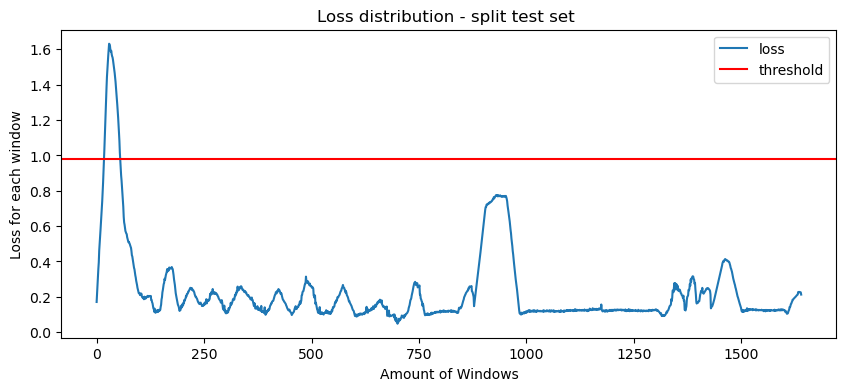

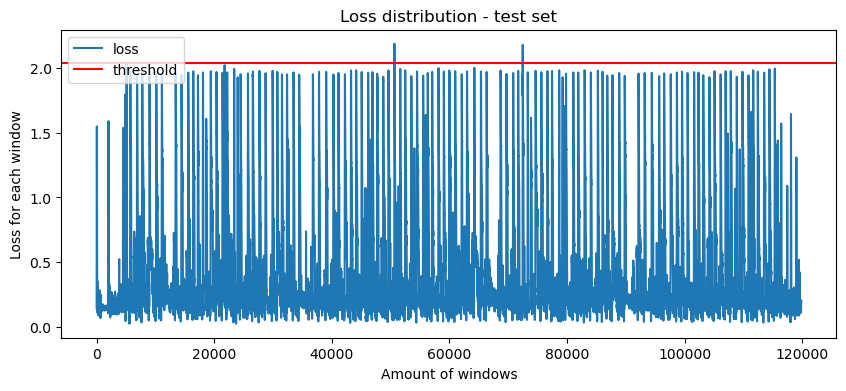

In [135]:
# Selection threshold

test_mae_loss_array = test_mae_loss.flatten()
plt.title('Loss distribution - split test set ')
plt.xlabel('Amount of Windows')
plt.ylabel('Loss for each window')
plt.plot(test_mae_loss_array, label='loss')
plt.axhline(threshold1, color='red', label='threshold')
plt.legend()
plt.show()

test_mae_loss_array2 = test_mae_loss2.flatten()
plt.title('Loss distribution - test set')
plt.xlabel('Amount of windows')
plt.ylabel('Loss for each window')
plt.plot(test_mae_loss_array2, label = 'loss')
plt.axhline(threshold2, color='red', label='threshold')
plt.legend()
plt.show()


In [140]:
sample

,Date,Train accel
0,2022-10-09 00:00:00,0.0
1,2022-10-09 00:00:00,0.0
2,2022-10-09 00:00:00,0.0
3,2022-10-09 00:00:00,0.0
4,2022-10-09 00:00:00,0.0
...,...,...
214371,2022-10-09 09:22:30,0.0
214372,2022-10-09 09:22:30,0.0
214373,2022-10-09 09:22:30,0.0
214374,2022-10-09 09:22:30,0.0


In [148]:
# shapes of data

dates_train = sample['Date'][:split_train_test]
dates_test = sample['Date'][split_train_test:]
dates_test2 = sample2['Date'][:No_of_test_windows2]

yes = sample
print(yes)
# ['Date', 'Train accel']

# No_of_test_windows = sample['Date'][split_train_test:]
# [:No_of_test_windows + window_length - 1]

y_pred = test_mae_loss_array >= threshold1
y_pred2 = test_mae_loss_array2 >= threshold2


print('Amount of test data in y_pred: ', y_pred.shape)
print('Amount of test data in 1st testing set: ', dates_test.shape)
print('Amount of test data in y_pred: ', y_pred2.shape)
print('Amount of test data in 2nd testing set: ', dates_test2.shape)

print('Amount of train data in split training set: ', dates_train[:-(window_length-1)].shape)

# print('Amount of test data in testing set: ', dates_test2[:-(window_length-1)].shape)
# print('Amount of test data in test_mae_loss_array2: ', y_pred2.shape)

                      Date  Train accel
0      2022-10-09 00:00:00          0.0
1      2022-10-09 00:00:00          0.0
2      2022-10-09 00:00:00          0.0
3      2022-10-09 00:00:00          0.0
4      2022-10-09 00:00:00          0.0
...                    ...          ...
214371 2022-10-09 09:22:30          0.0
214372 2022-10-09 09:22:30          0.0
214373 2022-10-09 09:22:30          0.0
214374 2022-10-09 09:22:30          0.0
214375 2022-10-09 09:22:30          0.0

[214376 rows x 2 columns]
Amount of test data in y_pred:  (1640,)
Amount of test data in 1st testing set:  (42876,)
Amount of test data in y_pred:  (119829,)
Amount of test data in 2nd testing set:  (119829,)
Amount of train data in split training set:  (171471,)


In [143]:
print(dates_test)
print(sample)

171500   2022-10-09 08:09:35
171501   2022-10-09 08:09:35
171502   2022-10-09 08:09:35
171503   2022-10-09 08:09:35
171504   2022-10-09 08:09:35
                 ...        
214371   2022-10-09 09:22:30
214372   2022-10-09 09:22:30
214373   2022-10-09 09:22:30
214374   2022-10-09 09:22:30
214375   2022-10-09 09:22:30
Name: Date, Length: 42876, dtype: datetime64[ns]
                      Date  Train accel
0      2022-10-09 00:00:00          0.0
1      2022-10-09 00:00:00          0.0
2      2022-10-09 00:00:00          0.0
3      2022-10-09 00:00:00          0.0
4      2022-10-09 00:00:00          0.0
...                    ...          ...
214371 2022-10-09 09:22:30          0.0
214372 2022-10-09 09:22:30          0.0
214373 2022-10-09 09:22:30          0.0
214374 2022-10-09 09:22:30          0.0
214375 2022-10-09 09:22:30          0.0

[214376 rows x 2 columns]


In [139]:
sample['Date']

# more = []
# for start in range(0, len(X) - length + 1):
#     window = X[start:start + length]
#     if np.std(window) > 1e-18 : #check if std is greater than 0
#         more.append(window)
# return np.array(more)
# #     if np.std(sample['Train accel']) > 1e-18 : #check if std is greater than 0


# def split_into_windows(X, length):
#     windows = []
#     for start in range(0, len(X) - length + 1):
#         window = X[start:start + length]
#         if np.std(window) > 1e-18 : #check if std is greater than 0
#             windows.append(window)
#     return np.array(windows)


# insert the date rows for when accel more than 0


index_jump = []

jump_row = None
for i in range(1, len(sample['Train accel'])):
    date_diff = sample['Date'][i] - sample['Date'][i-1]
    if date_diff > pd.Timedelta(seconds=1):
    if np.std() > 1e-18 : #check if std is greater than 0

        print(f"Found a sudden jump between {sample['Date'][i-1]} and {sample['Date'][i]}")
        index_jump.append(i)
        jump_row = i

print({index_jump})

NameError: name 'X' is not defined

In [57]:
# dates_test
print(No_of_test_windows)

1640


In [59]:
# Dates where anomalies have been detected


dates_with_anomalies = dates_test[y_pred]
dates_with_anomalies2 = dates_test2[y_pred2] #real test data
# dates_test and y_pred to have same length, if not IndexError: Boolean index has wrong length: 2101 instead of 85722


print('Dates in split test data where anomalies have been detected:')
for a in dates_with_anomalies: #print each date one by one
    print(a)
    
    
print('Dates in 2nd test data where anomalies have been detected:')
for b in dates_with_anomalies2: #print each date one by one
    print(b) 

IndexError: Boolean index has wrong length: 1640 instead of 42876

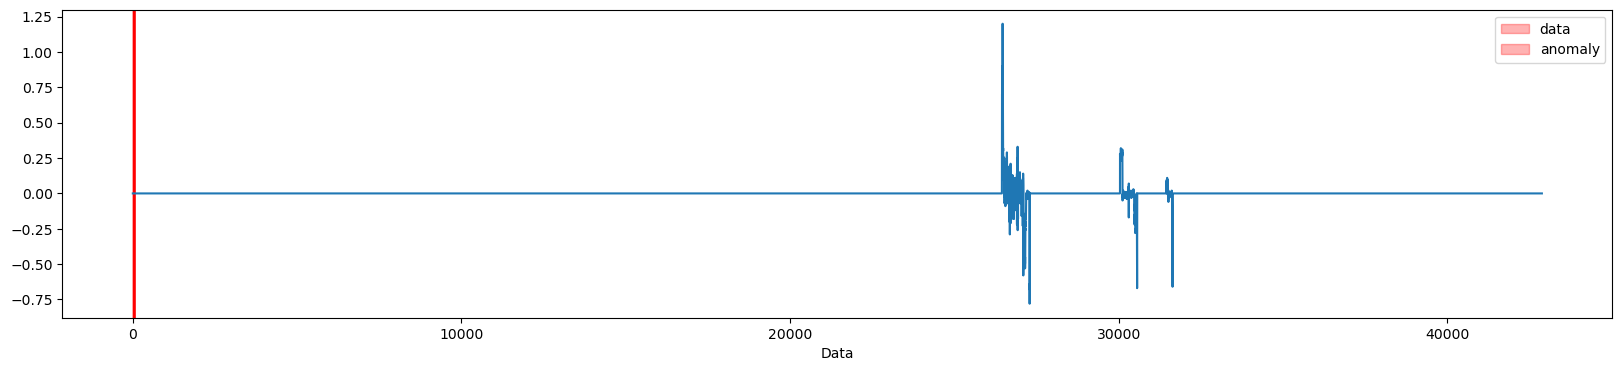

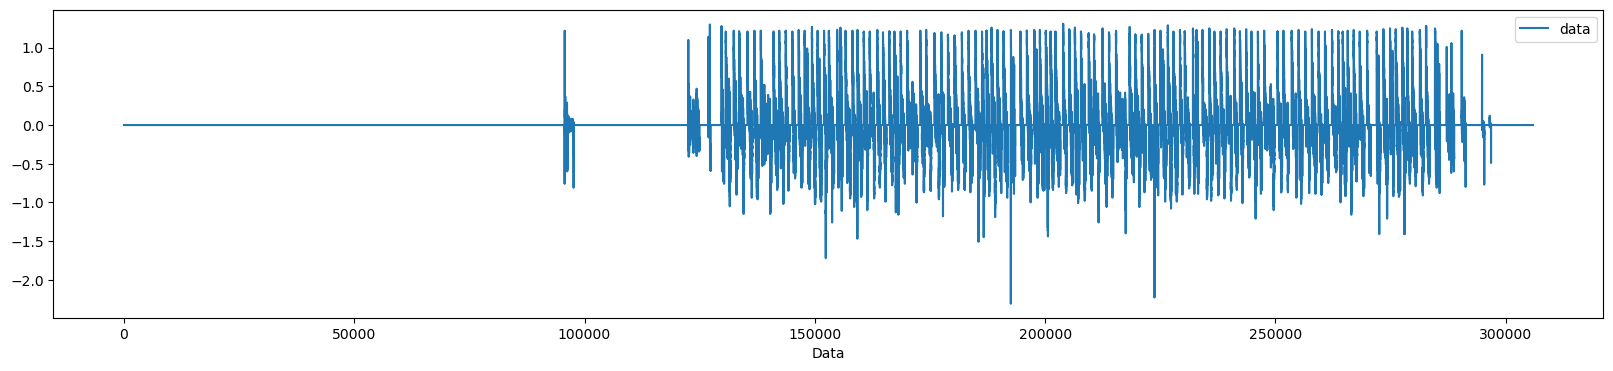

In [56]:
index = ['Date']

indexes = []
for d in dates_with_anomalies:
    index_low = np.where(dates_test == d)
    d_temp = d  + np.timedelta64(int(window_length / 2), 'h')
    indexes.append(index_low[0][0])
    
plt.figure(figsize=(20,4))
for index in indexes:
    plt.axvspan(index, index, color='r', alpha=0.3)
plt.plot(scaler.inverse_transform(test).flatten())
plt.xlabel('Data')
plt.legend(['data', 'anomaly'])
plt.show()





indexes2 = []
for d in dates_with_anomalies2:
    index_low = np.where(dates_test2 == d)
    d_temp = d  + np.timedelta64(int(window_length / 2), 'h')
    indexes2.append(index_low[0][0])

plt.figure(figsize=(20,4))
for index in indexes2:
    plt.axvspan(index, index, color='r', alpha=0.3)
plt.plot(scaler.inverse_transform(test2).flatten())
plt.xlabel('Data')
plt.legend(['data', 'anomaly'])
plt.show()